In [ ]:
from xai.policy import *
from torchvision.datasets.mnist import MNIST
import matplotlib.pyplot as plt

import torch
import random

In [ ]:
mnist = MNIST(".", download=True)
images = mnist.data.float()/255.0

labels = torch.zeros((mnist.data.shape[0],10)).float()
labels[torch.arange(0,mnist.data.shape[0]),mnist.targets] = 1.0

images.shape, labels.shape

In [ ]:
encoder = Policy.new((28,28),10, hidden_layers=2)
decoder = Policy.new(10,(28,28), hidden_layers=2)
autoencoder = encoder + decoder
autoencoder

In [ ]:
autoencoder.adam().fit(
    X=images,
    Y=images,
    steps=5000,
    batch_size=64,
    loss_criterion="HuberLoss",
    verbose=True
)

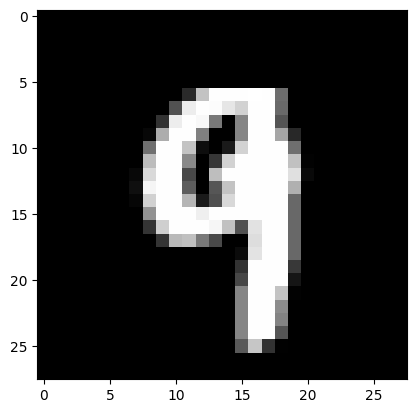

In [61]:
sample = images[random.randint(0,len(images))]
plt.imshow(sample, cmap="gray")

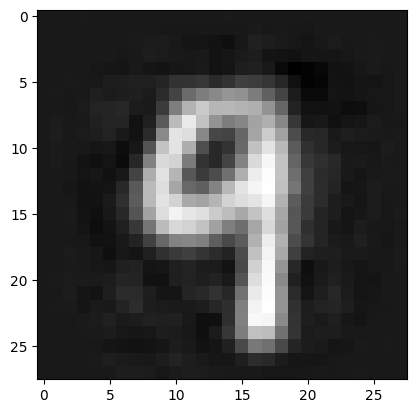

In [62]:
reconstruction = autoencoder(sample)
reconstruction.show()

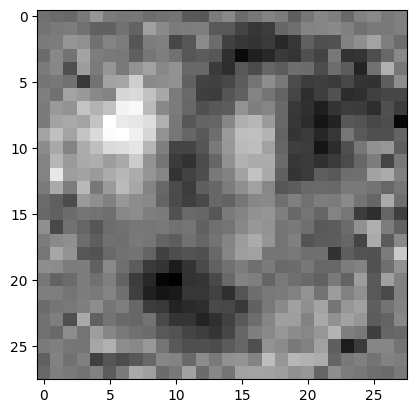

In [66]:
latent = encoder(sample)
plt.imshow(latent.gradients(lambda t: t.sum()), cmap="gray")